In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
from transformers import CLIPModel, CLIPProcessor, CLIPConfig
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import pathlib
import zipfile
import rarfile

In [4]:
!pip install rarfile

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
model.eval()
model = model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

In [51]:
def preprocess(image, image_size=(336, 336)):
    transform = transforms.Compose([
        transforms.Resize(image_size, interpolation=Image.BILINEAR),
        transforms.CenterCrop(image_size),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)


In [79]:
def extract_features(image_batch, model, preprocess_func):
    try:
        if isinstance(image_batch, (list, tuple)):
            input_tensor = torch.stack([preprocess_func(transforms.ToTensor()(img)) for img in image_batch]).to(model.device)
        else:
            input_tensor = preprocess_func(transforms.ToTensor()(image_batch)).unsqueeze(0).to(model.device)
        with torch.no_grad():
            features = model.get_image_features(input_tensor).flatten(start_dim=1).detach().cpu().numpy()
            return features
    except Exception as e:
        print(f"Ошибка при обработке батча изображений: {e}")
        import traceback
        traceback.print_exc()
        return None


In [53]:
def collect_data(data_dir):
    image_paths = []
    labels = []
    def walk_dir(dirpath, name):
        if os.path.isdir(dirpath):
            for subdir, dirs, files in os.walk(dirpath):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')):
                        image_path = os.path.join(subdir, file)
                        image_paths.append(image_path)
                        labels.append(name)
        else:
            pass


    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        walk_dir(category_path, category)

    return image_paths, labels


data_dir = '/content/drive/MyDrive/Dataset_all_class'
image_paths, labels = collect_data(data_dir)

In [56]:
def create_dataset(image_paths, labels, transform=None):
    class ImageDataset(torch.utils.data.Dataset):
        def __init__(self, image_paths, labels, transform=None):
            self.image_paths = image_paths
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            image = Image.open(self.image_paths[idx]).convert('RGB')
            image = image.resize((336, 336), Image.BILINEAR)
            image = transforms.ToTensor()(image)
            image = preprocess(image)
            return image, self.labels[idx]

    return ImageDataset(image_paths, labels, transform=preprocess)

In [58]:
dataset = create_dataset(image_paths, labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

checkpoint_interval = 10
features_all = []
labels_all = []

checkpoint_dir = "checkpoints"
pathlib.Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

for i, batch in enumerate(tqdm(dataloader, desc="Извлечение признаков")):
    images, batch_labels = batch
    batch_features = extract_features(images, model, preprocess)
    if batch_features is not None:
        features_all.extend(batch_features)
        labels_all.extend(batch_labels)

    if (i + 1) % checkpoint_interval == 0:
        checkpoint_path_features = os.path.join(checkpoint_dir, f"features_checkpoint_{i+1}.npy")
        checkpoint_path_labels = os.path.join(checkpoint_dir, f"labels_checkpoint_{i+1}.npy")
        np.save(checkpoint_path_features, np.array(features_all))
        np.save(checkpoint_path_labels, np.array(labels_all))
        print(f"Чекпоинт сохранен: {checkpoint_path_features}, {checkpoint_path_labels}")

X = np.array(features_all)
y = np.array(labels_all)

print("Извлечение признаков завершено!")
np.save("features_final.npy", X)
np.save("labels_final.npy", y)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Извлечение признаков:   3%|▎         | 10/321 [00:37<17:21,  3.35s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_10.npy, checkpoints/labels_checkpoint_10.npy


Извлечение признаков:   6%|▌         | 20/321 [01:11<16:41,  3.33s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_20.npy, checkpoints/labels_checkpoint_20.npy


Извлечение признаков:   9%|▉         | 30/321 [01:45<16:43,  3.45s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_30.npy, checkpoints/labels_checkpoint_30.npy


Извлечение признаков:  12%|█▏        | 40/321 [02:19<16:15,  3.47s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_40.npy, checkpoints/labels_checkpoint_40.npy


Извлечение признаков:  16%|█▌        | 50/321 [02:54<16:06,  3.57s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_50.npy, checkpoints/labels_checkpoint_50.npy


Извлечение признаков:  19%|█▊        | 60/321 [03:30<15:20,  3.53s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_60.npy, checkpoints/labels_checkpoint_60.npy


Извлечение признаков:  22%|██▏       | 70/321 [04:05<14:34,  3.48s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_70.npy, checkpoints/labels_checkpoint_70.npy


Извлечение признаков:  25%|██▍       | 80/321 [05:27<39:38,  9.87s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_80.npy, checkpoints/labels_checkpoint_80.npy


Извлечение признаков:  28%|██▊       | 90/321 [06:28<23:07,  6.01s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_90.npy, checkpoints/labels_checkpoint_90.npy


Извлечение признаков:  31%|███       | 100/321 [07:53<35:31,  9.64s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_100.npy, checkpoints/labels_checkpoint_100.npy


Извлечение признаков:  34%|███▍      | 110/321 [09:01<24:58,  7.10s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_110.npy, checkpoints/labels_checkpoint_110.npy


Извлечение признаков:  37%|███▋      | 120/321 [10:40<29:20,  8.76s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_120.npy, checkpoints/labels_checkpoint_120.npy


Извлечение признаков:  40%|████      | 130/321 [12:00<28:20,  8.90s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_130.npy, checkpoints/labels_checkpoint_130.npy


Извлечение признаков:  44%|████▎     | 140/321 [13:12<21:21,  7.08s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_140.npy, checkpoints/labels_checkpoint_140.npy


Извлечение признаков:  47%|████▋     | 150/321 [14:29<25:30,  8.95s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_150.npy, checkpoints/labels_checkpoint_150.npy


Извлечение признаков:  50%|████▉     | 160/321 [15:39<18:28,  6.88s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_160.npy, checkpoints/labels_checkpoint_160.npy


Извлечение признаков:  53%|█████▎    | 170/321 [17:04<23:47,  9.46s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_170.npy, checkpoints/labels_checkpoint_170.npy


Извлечение признаков:  56%|█████▌    | 180/321 [18:23<22:01,  9.37s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_180.npy, checkpoints/labels_checkpoint_180.npy


Извлечение признаков:  59%|█████▉    | 190/321 [19:37<16:36,  7.61s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_190.npy, checkpoints/labels_checkpoint_190.npy


Извлечение признаков:  62%|██████▏   | 200/321 [21:03<19:28,  9.66s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_200.npy, checkpoints/labels_checkpoint_200.npy


Извлечение признаков:  65%|██████▌   | 210/321 [22:31<15:00,  8.11s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_210.npy, checkpoints/labels_checkpoint_210.npy


Извлечение признаков:  69%|██████▊   | 220/321 [24:15<17:12, 10.22s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_220.npy, checkpoints/labels_checkpoint_220.npy


Извлечение признаков:  72%|███████▏  | 230/321 [25:19<09:39,  6.36s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_230.npy, checkpoints/labels_checkpoint_230.npy


Извлечение признаков:  75%|███████▍  | 240/321 [26:35<12:08,  8.99s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_240.npy, checkpoints/labels_checkpoint_240.npy


Извлечение признаков:  78%|███████▊  | 250/321 [27:39<07:21,  6.22s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_250.npy, checkpoints/labels_checkpoint_250.npy


Извлечение признаков:  81%|████████  | 260/321 [28:55<08:18,  8.18s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_260.npy, checkpoints/labels_checkpoint_260.npy


Извлечение признаков:  84%|████████▍ | 270/321 [29:58<05:05,  5.99s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_270.npy, checkpoints/labels_checkpoint_270.npy


Извлечение признаков:  87%|████████▋ | 280/321 [31:31<07:32, 11.03s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_280.npy, checkpoints/labels_checkpoint_280.npy


Извлечение признаков:  90%|█████████ | 290/321 [32:40<03:28,  6.72s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_290.npy, checkpoints/labels_checkpoint_290.npy


Извлечение признаков:  93%|█████████▎| 300/321 [34:01<02:44,  7.85s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_300.npy, checkpoints/labels_checkpoint_300.npy


Извлечение признаков:  97%|█████████▋| 310/321 [35:09<01:16,  6.97s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_310.npy, checkpoints/labels_checkpoint_310.npy


Извлечение признаков: 100%|█████████▉| 320/321 [36:35<00:10, 10.81s/it]

Чекпоинт сохранен: checkpoints/features_checkpoint_320.npy, checkpoints/labels_checkpoint_320.npy


Извлечение признаков: 100%|██████████| 321/321 [36:36<00:00,  6.84s/it]

Извлечение признаков завершено!


In [74]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import io

In [68]:
X = np.load("features_final.npy")
y = np.load("labels_final.npy")

le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.long)

X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42) # 30% на валидацию и тест
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # поровну валидация и тест

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.device = device

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    def predict(self, features):
        with torch.no_grad():
            output = self(torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(self.device))
            _, predicted = torch.max(output.data, 1)
            return predicted.item()

train_losses = []
val_losses = []


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 768  # Размерность вектора
hidden_size = 512
num_classes = 15
mlp = MLP(input_size, hidden_size, num_classes, device).to(device)
# mlp.load_state_dict(torch.load("mlp_model.pth"))
mlp.eval()

optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


epochs = 80
for epoch in range(epochs):
    mlp.train()
    optimizer.zero_grad()
    outputs = mlp(X_train.to(model.device))
    train_loss = criterion(outputs, y_train.to(model.device))
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    mlp.eval()
    with torch.no_grad():
        val_outputs = mlp(X_val.to(model.device))
        val_loss = criterion(val_outputs, y_val.to(model.device))
        val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [1/80], Train Loss: 2.7124, Val Loss: 2.4816
Epoch [2/80], Train Loss: 2.4803, Val Loss: 2.2868
Epoch [3/80], Train Loss: 2.2786, Val Loss: 2.0968
Epoch [4/80], Train Loss: 2.0822, Val Loss: 1.9034
Epoch [5/80], Train Loss: 1.8840, Val Loss: 1.7091
Epoch [6/80], Train Loss: 1.6875, Val Loss: 1.5234
Epoch [7/80], Train Loss: 1.5020, Val Loss: 1.3549
Epoch [8/80], Train Loss: 1.3358, Val Loss: 1.2082
Epoch [9/80], Train Loss: 1.1921, Val Loss: 1.0834
Epoch [10/80], Train Loss: 1.0698, Val Loss: 0.9781
Epoch [11/80], Train Loss: 0.9652, Val Loss: 0.8897
Epoch [12/80], Train Loss: 0.8757, Val Loss: 0.8172
Epoch [13/80], Train Loss: 0.8008, Val Loss: 0.7583
Epoch [14/80], Train Loss: 0.7393, Val Loss: 0.7085
Epoch [15/80], Train Loss: 0.6875, Val Loss: 0.6662
Epoch [16/80], Train Loss: 0.6437, Val Loss: 0.6311
Epoch [17/80], Train Loss: 0.6071, Val Loss: 0.6017
Epoch [18/80], Train Loss: 0.5754, Val Loss: 0.5774
Epoch [19/80], Train Loss: 0.5482, Val Loss: 0.5579
Epoch [20/80], Train 

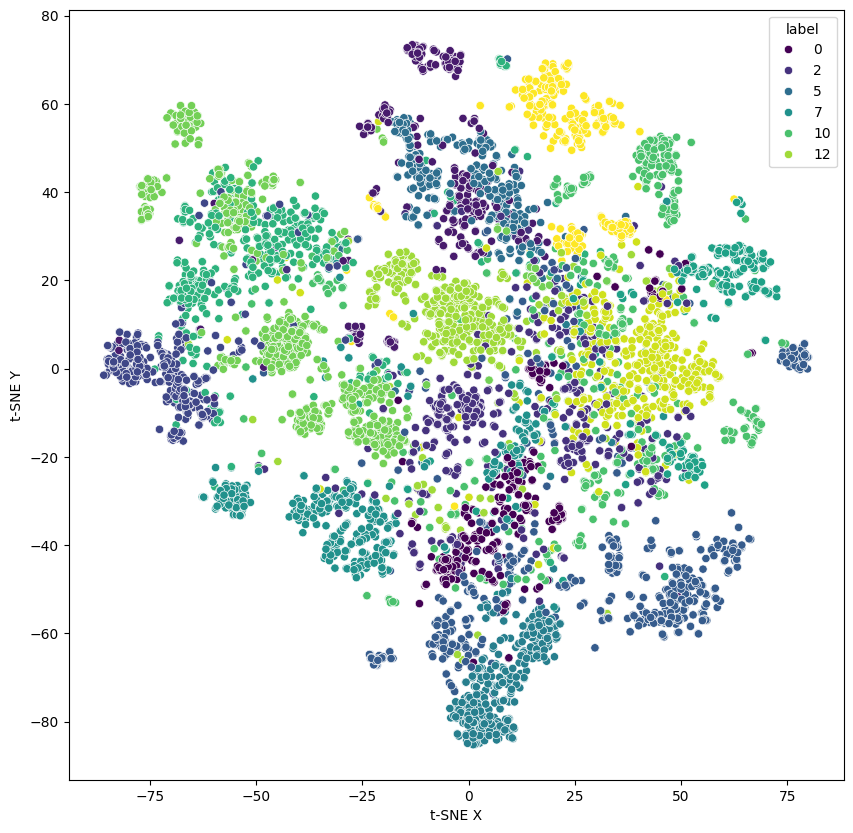

In [65]:
#cluster
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X_train)
df = pd.DataFrame(X_embedded, columns=['tsne-x', 'tsne-y'])
df['label'] = y_train

plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='tsne-x', y='tsne-y', hue='label', palette='viridis')
plt.xlabel('t-SNE X')
plt.ylabel('t-SNE Y')
plt.show()

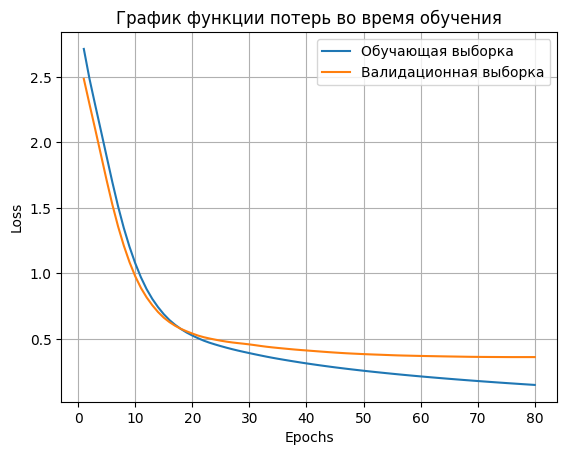

In [66]:
#Loss func
plt.plot(range(1, epochs + 1), train_losses, label="Обучающая выборка")
plt.plot(range(1, epochs + 1), val_losses, label="Валидационная выборка")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("График функции потерь во время обучения")
plt.legend()
plt.grid(True)
plt.show()

In [75]:
mlp.eval()
with torch.no_grad():
    outputs = mlp(X_test.to(model.device))
    _, predicted = torch.max(outputs.data, 1)
    print(classification_report(y_test.cpu(), predicted.cpu(), target_names=le.classes_))

accuracy = accuracy_score(y_test.cpu(), predicted.cpu())
print(f"Общая точность (Accuracy): {accuracy:.4f}")

                           precision    recall  f1-score   support

               Археология       0.87      0.90      0.88        72
                  Графика       0.95      0.90      0.93        82
                      ДПИ       0.76      0.76      0.76       115
                Документы       0.90      0.86      0.88        85
Естественнонауч.коллекция       0.92      0.90      0.91       157
                 Живопись       0.92      0.90      0.91        86
              Минералогия       0.95      0.96      0.96        81
              Нумизматика       0.88      0.90      0.89       111
                   Оружие       0.87      0.97      0.92        70
       Печатная продукция       0.80      0.84      0.82        95
                   Прочие       0.80      0.74      0.77       136
             Редкие книги       0.96      0.97      0.96       195
               Скульптура       0.90      0.89      0.90        83
                  Техника       0.81      0.87      0.84     

In [70]:
torch.save(mlp.state_dict(), "mlp_model.pth")
np.save("label_encoder.npy", le.classes_)

In [81]:
#Если есть label_encoder.npy и mlp_model.pth, возвращаем классы изображений из архива
def predict_class(features, mlp, le):
    try:
        features_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0).to(mlp.device) # Перемещаем на устройство mlp
        predicted_index = mlp(features_tensor).argmax().item()
        predicted_class = le.inverse_transform([predicted_index])[0]
        return predicted_class
    except Exception as e:
        print(f"Ошибка при предсказании класса: {e}")
        import traceback
        traceback.print_exc()
        return None

le = LabelEncoder()
le.classes_ = np.load("label_encoder.npy", allow_pickle=True)

def predict_archive(archive_path, model, mlp, le, preprocess):
    results = {}
    try:
        opener = rarfile.RarFile if archive_path.lower().endswith(".rar") else zipfile.ZipFile
        with opener(archive_path, 'r') as archive:
            for member in archive.infolist():
                if member.filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                    try:
                        with archive.open(member) as f:
                            image = Image.open(io.BytesIO(f.read())).convert('RGB')
                            features = extract_features(image, model, preprocess)
                            if features is not None:
                                predicted_class = predict_class(features, mlp, le)
                                if predicted_class:
                                    results[member.filename] = predicted_class
                    except Exception as e:
                        print(f"Ошибка при обработке файла {member.filename}: {e}")
        return results
    except FileNotFoundError:
        print(f"Архив {archive_path} не найден.")
        return None
    except Exception as e:
        print(f"Ошибка при чтении архива: {e}")
        return None


archive_path = "/content/Example.rar"
results = predict_archive(archive_path, model, mlp, le, preprocess)

if results:
    for filename, predicted_class in results.items():
        print(f"Изображение: {filename}, Предсказанный класс: {predicted_class}")
else:
    print("Ошибка при предсказании.")

Изображение: 49BUAYoWvOOSYa0MIPoI2oUJwugOg2hB7Xbf67Wy.jpg, Предсказанный класс: Живопись
Изображение: Археология-500x376.jpg, Предсказанный класс: Археология


In [ ]:
'''features = extract_features(image_path, model, preprocess)
if features is not None:
    print(features.shape)
    predicted_class = predict_class(features, mlp, le)'''

(1, 768)
